In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

from sklearn.calibration import LabelEncoder
from geopy.distance import geodesic

In [2]:
data = pd.read_csv('credit_card_transactions.csv')
data = data.drop(data.columns[0], axis=1)

In [3]:
data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop          

Encoder Features

In [5]:
encoder = LabelEncoder()
data['merchant'] = encoder.fit_transform(data['merchant'])
merchant_label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

In [6]:
merchant_label_mapping

{'fraud_Abbott-Rogahn': np.int64(0),
 'fraud_Abbott-Steuber': np.int64(1),
 'fraud_Abernathy and Sons': np.int64(2),
 'fraud_Abshire PLC': np.int64(3),
 'fraud_Adams, Kovacek and Kuhlman': np.int64(4),
 'fraud_Adams-Barrows': np.int64(5),
 'fraud_Altenwerth, Cartwright and Koss': np.int64(6),
 'fraud_Altenwerth-Kilback': np.int64(7),
 'fraud_Ankunding LLC': np.int64(8),
 'fraud_Ankunding-Carroll': np.int64(9),
 'fraud_Armstrong, Walter and Gottlieb': np.int64(10),
 'fraud_Auer LLC': np.int64(11),
 'fraud_Auer-Mosciski': np.int64(12),
 'fraud_Auer-West': np.int64(13),
 'fraud_Bahringer Group': np.int64(14),
 'fraud_Bahringer, Bergnaum and Quitzon': np.int64(15),
 'fraud_Bahringer, Osinski and Block': np.int64(16),
 'fraud_Bahringer, Schoen and Corkery': np.int64(17),
 'fraud_Bahringer-Larson': np.int64(18),
 'fraud_Bahringer-Streich': np.int64(19),
 'fraud_Bailey-Morar': np.int64(20),
 'fraud_Balistreri-Nader': np.int64(21),
 'fraud_Barrows PLC': np.int64(22),
 'fraud_Bartoletti and Son

Transaction Time Features

In [7]:
# Hora
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
data['transaction_hour'] = data['trans_date_trans_time'].dt.hour

In [8]:
# Día
data['transaction_day_of_week'] = data['trans_date_trans_time'].dt.dayofweek

In [9]:
# Tiempo transcurrido desde la última transacción (Segundos)
data = data.sort_values(by=['cc_num', 'trans_date_trans_time'])
data['time_since_last_trans'] = data.groupby('cc_num')['trans_date_trans_time'].diff().dt.total_seconds()

Amount Features

In [10]:
# Amount Features
bins = [0, 50, 100, 500, 1000, data['amt'].max()]
labels = ['very_low', 'low', 'medium', 'high', 'very_high']
data['amt_category'] = pd.cut(data['amt'], bins=bins, labels=labels)

Location-Based Features

In [11]:
# Distancia entre el cliente y el comerciante
data['distance'] = data.apply(lambda row: geodesic((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])).miles, axis=1)

Demographic Features

In [12]:
# Edad Demográfica del Cliente
data['dob'] = pd.to_datetime(data['dob'])
data['age'] = (pd.to_datetime('today') - data['dob']).dt.days // 365

Risk-Related Features

In [13]:
# Tasa de fraude de comerciantes o de Estado
data['merchant_fraud_ratio'] = data.groupby('merchant')['is_fraud'].transform('mean')
data['state_fraud_rate'] = data.groupby('state')['is_fraud'].transform('mean')

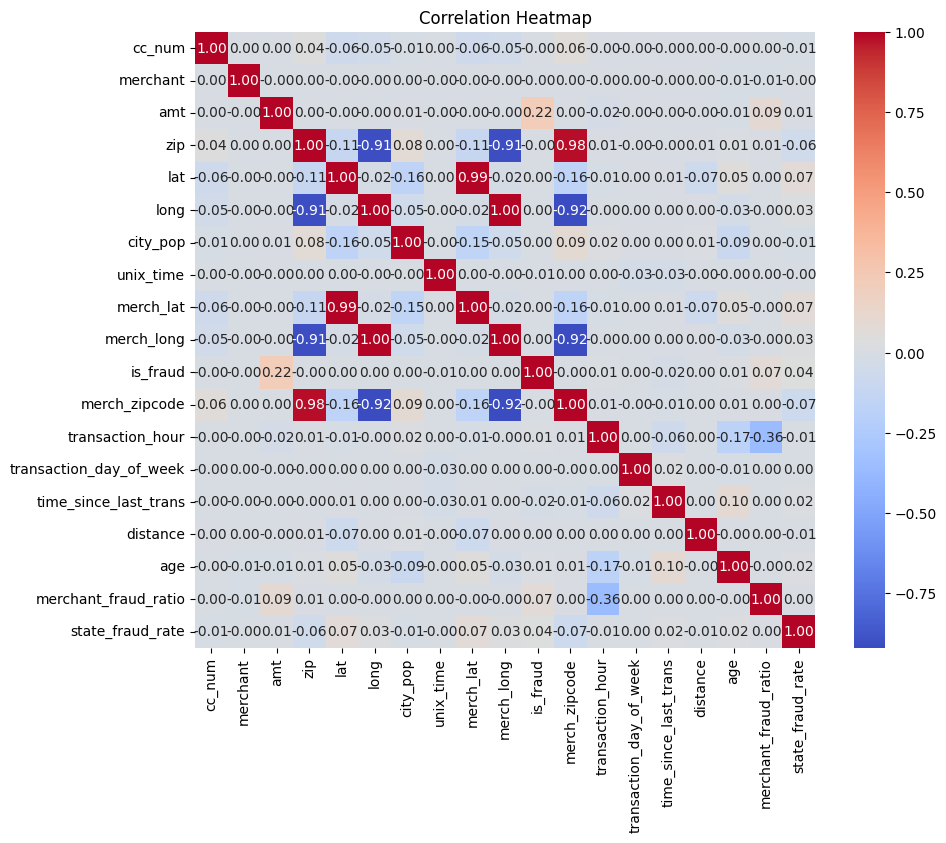

In [14]:
correlation_matrix = data.corr(numeric_only=True)
correlation_matrix

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

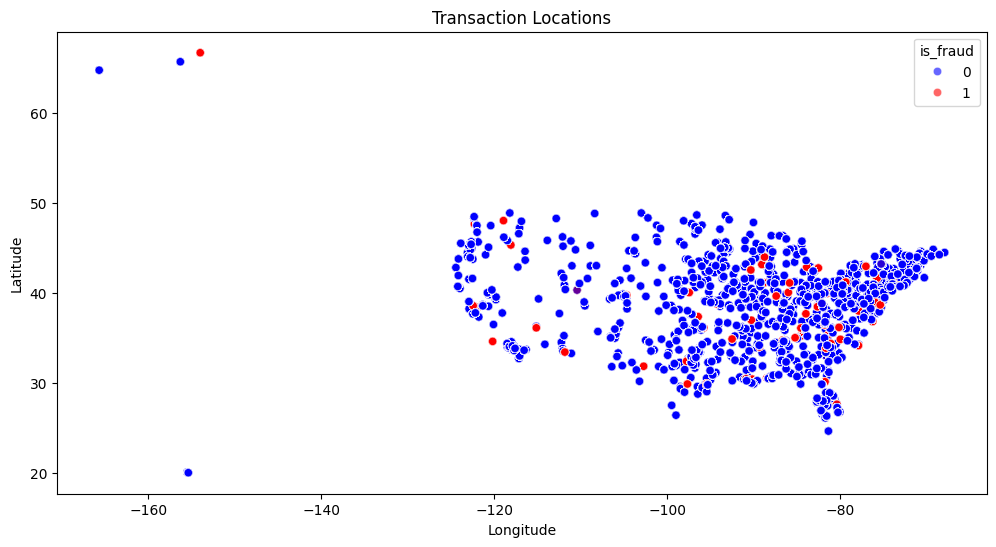

In [15]:
# Plot location of transactions colored by fraud status
plt.figure(figsize=(12, 6))
sns.scatterplot(data=data, x='long', y='lat', hue='is_fraud', palette={0: 'blue', 1: 'red'}, alpha=0.6)
plt.title('Transaction Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

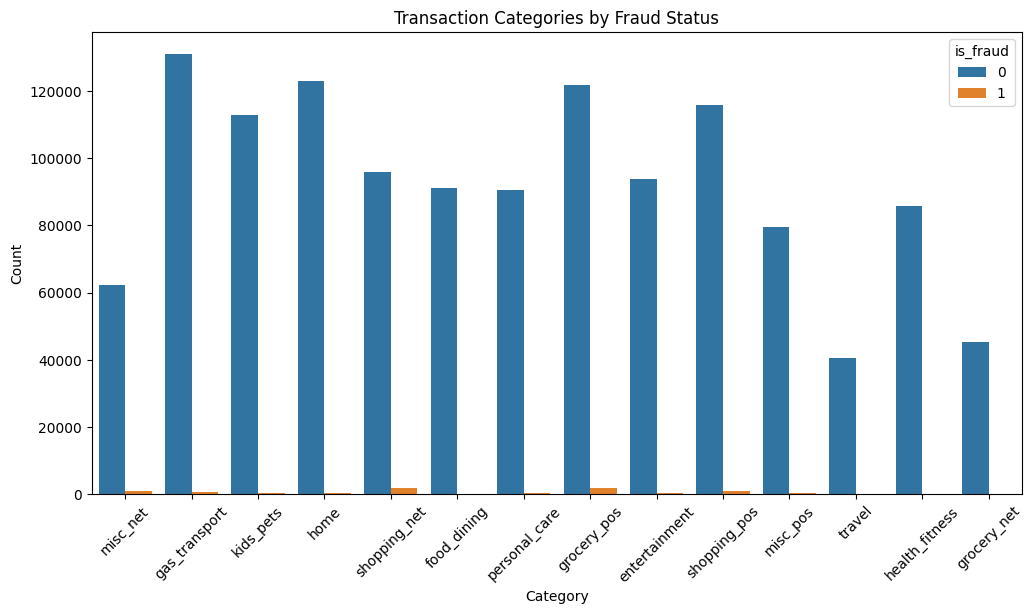

In [16]:
# Plot the distribution of transaction categories
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='category', hue='is_fraud')
plt.title('Transaction Categories by Fraud Status')
plt.xticks(rotation=45)
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

### Prueba del proceso de selección de características

In [17]:
from sklearn.model_selection import train_test_split

X = data[['transaction_hour', 'transaction_day_of_week', 'time_since_last_trans', 
          'amt_category', 'distance', 'age', 'merchant_fraud_ratio', 'state_fraud_rate']]
y = data['is_fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Transformación de datos
numeric_features = ['transaction_hour', 'time_since_last_trans', 'distance', 'age', 'merchant_fraud_ratio', 'state_fraud_rate']
categorical_features = ['amt_category', 'transaction_day_of_week']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)])

# Pipeline con preprocesador y modelo
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier(random_state=42))])

# Entrenamiento del modelo
clf.fit(X_train, y_train)

# Predicciones
y_pred = clf.predict(X_test)


In [19]:
# Métricas de evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9935938797387167
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    386717
           1       0.46      0.49      0.47      2286

    accuracy                           0.99    389003
   macro avg       0.73      0.74      0.73    389003
weighted avg       0.99      0.99      0.99    389003



In [20]:
importances = clf.named_steps['classifier'].feature_importances_
numeric_feature_names = preprocessor.transformers_[0][1].get_feature_names_out(numeric_features)
categorical_feature_names = preprocessor.transformers_[1][1].get_feature_names_out(categorical_features)

# Nombres de las características
feature_names = list(numeric_feature_names) + list(categorical_feature_names)

# Mostrar la importancia de cada característica
if len(importances) == len(feature_names):
    feature_importances = pd.DataFrame(importances, index=feature_names, columns=['importance']).sort_values(by='importance', ascending=False)
    print(feature_importances)

                           importance
transaction_hour             0.177814
age                          0.165234
time_since_last_trans        0.158309
merchant_fraud_ratio         0.151762
distance                     0.116614
amt_category_high            0.076774
state_fraud_rate             0.060639
amt_category_very_high       0.031120
transaction_day_of_week_1    0.009885
transaction_day_of_week_6    0.008481
transaction_day_of_week_4    0.008006
transaction_day_of_week_2    0.007611
transaction_day_of_week_5    0.007584
transaction_day_of_week_0    0.007319
amt_category_medium          0.006878
transaction_day_of_week_3    0.004565
amt_category_very_low        0.000970
amt_category_low             0.000435


## Modelización. 
Comprende el entrenamiento de dos o más algoritmos propuestos a fin de obtener conocimiento a partir de los datos preparados. Comprobar el rendimiento de los modelos creados y experimentar con ellos con datos de prueba para realizar las clasificaciones / predicciones.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

In [22]:
y = data['is_fraud']
X = data.drop(columns=['is_fraud', 'trans_date_trans_time', 'cc_num', 'merchant', 'street', 'city', 
                       'state', 'zip', 'lat', 'long', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'category'])

In [23]:
# Manejar variables categóricas
X = pd.get_dummies(X, drop_first=True)

In [24]:
# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [25]:
# Escalar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Entrenando modelo: Linear Regression
Accuracy del modelo Linear Regression: 0.9948

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    257834
           1       1.00      0.09      0.17      1501

    accuracy                           0.99    259335
   macro avg       1.00      0.55      0.58    259335
weighted avg       0.99      0.99      0.99    259335



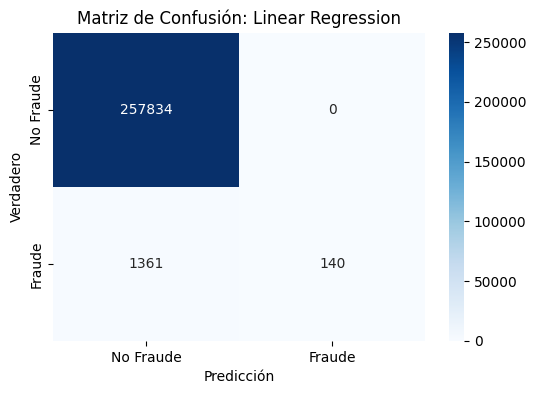


Entrenando modelo: Logistic Regression
Accuracy del modelo Logistic Regression: 0.9953

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.81      0.26      0.39      1501

    accuracy                           1.00    259335
   macro avg       0.90      0.63      0.69    259335
weighted avg       0.99      1.00      0.99    259335



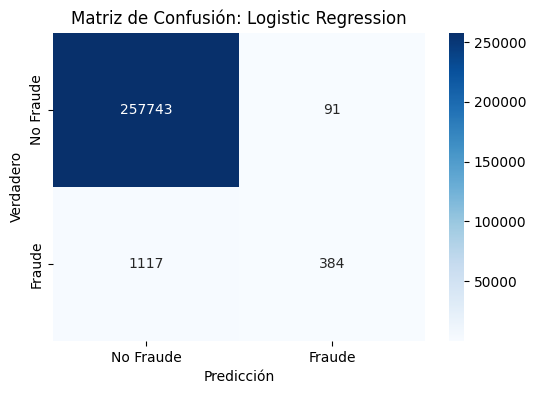


Entrenando modelo: Random Forest
Accuracy del modelo Random Forest: 0.9677

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    257834
           1       0.13      0.78      0.22      1501

    accuracy                           0.97    259335
   macro avg       0.56      0.87      0.60    259335
weighted avg       0.99      0.97      0.98    259335



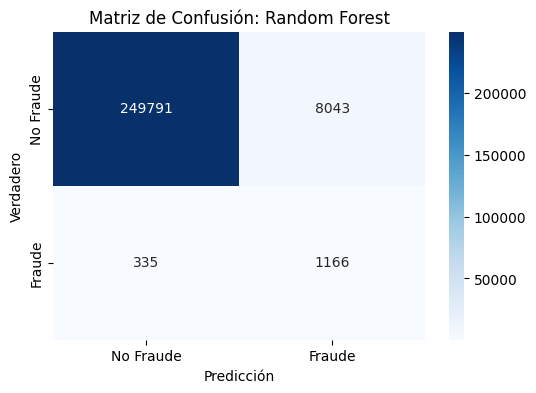

C:\Users\magic\AppData\Local\Temp\ipykernel_2076\733260261.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Modelo', y='Accuracy', data=results_df, palette='viridis')


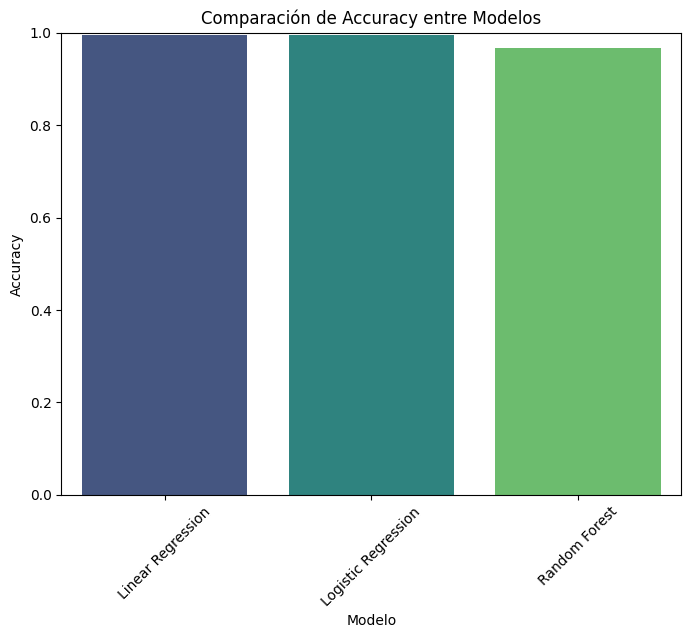

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Manejar valores faltantes
imputer = SimpleImputer(strategy='mean')  # Rellenar NaN con la media
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Lista de modelos a entrenar
models = {
    'Linear Regression': LinearRegression(),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced')
}

# Variables para almacenar resultados
results = []

# Entrenar y evaluar cada modelo
for name, model in models.items():
    print(f"\nEntrenando modelo: {name}")
    model.fit(X_train, y_train)
    
    if name == 'Linear Regression':
        # Para regresión lineal: convertir predicciones a clases binarias
        y_pred = model.predict(X_test)
        y_pred = (y_pred >= 0.5).astype(int)  # Umbral de 0.5
    else:
        # Para modelos de clasificación
        y_pred = model.predict(X_test)
    
    # Evaluación del modelo
    acc = accuracy_score(y_test, y_pred)
    results.append({'Modelo': name, 'Accuracy': acc})
    print(f"Accuracy del modelo {name}: {acc:.4f}")
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraude', 'Fraude'], yticklabels=['No Fraude', 'Fraude'])
    plt.title(f'Matriz de Confusión: {name}')
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    plt.show()

# Visualización de Accuracy entre los modelos
results_df = pd.DataFrame(results)
plt.figure(figsize=(8, 6))
sns.barplot(x='Modelo', y='Accuracy', data=results_df, palette='viridis')
plt.title('Comparación de Accuracy entre Modelos')
plt.ylabel('Accuracy')
plt.xlabel('Modelo')
plt.ylim(0, 1)  # Accuracy está entre 0 y 1
plt.xticks(rotation=45)
plt.show()



### Tuning de Hiperparametros. Realizar una técnica avanzada de tuning de hiperparametros sobre los modelos propuestos.


Evaluación de Modelos con las 5 Características más Importantes:

Logistic Regression - Ajuste de Hiperparámetros
Mejores parámetros: {'solver': 'liblinear', 'max_iter': 100, 'C': 0.1}
Logistic Regression - Accuracy: 0.9935
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     25779
           1       0.00      0.00      0.00       155

    accuracy                           0.99     25934
   macro avg       0.50      0.50      0.50     25934
weighted avg       0.99      0.99      0.99     25934



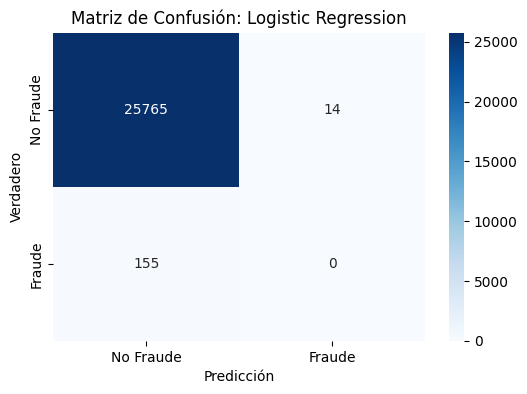


Random Forest - Ajuste de Hiperparámetros
Mejores parámetros: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'class_weight': 'balanced'}
Random Forest - Accuracy: 0.9946
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25779
           1       0.63      0.21      0.32       155

    accuracy                           0.99     25934
   macro avg       0.81      0.61      0.66     25934
weighted avg       0.99      0.99      0.99     25934



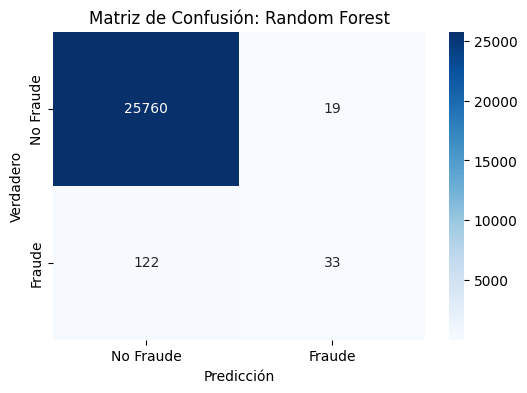


Linear Regression - Ajuste de Hiperparámetros
Linear Regression no requiere ajuste de hiperparámetros.
Linear Regression - Accuracy: 0.9938
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     25779
           1       0.00      0.00      0.00       155

    accuracy                           0.99     25934
   macro avg       0.50      0.50      0.50     25934
weighted avg       0.99      0.99      0.99     25934



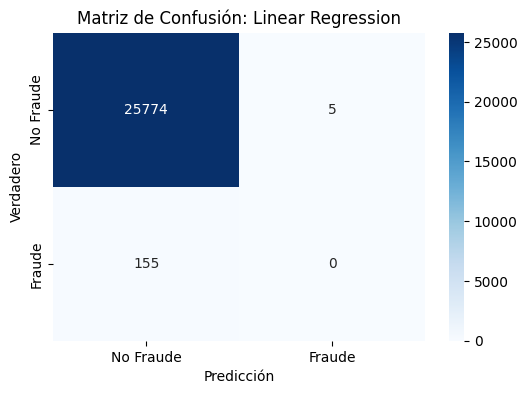

C:\Users\magic\AppData\Local\Temp\ipykernel_2076\916982142.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Modelo', y='Accuracy', data=results_df, palette='viridis')


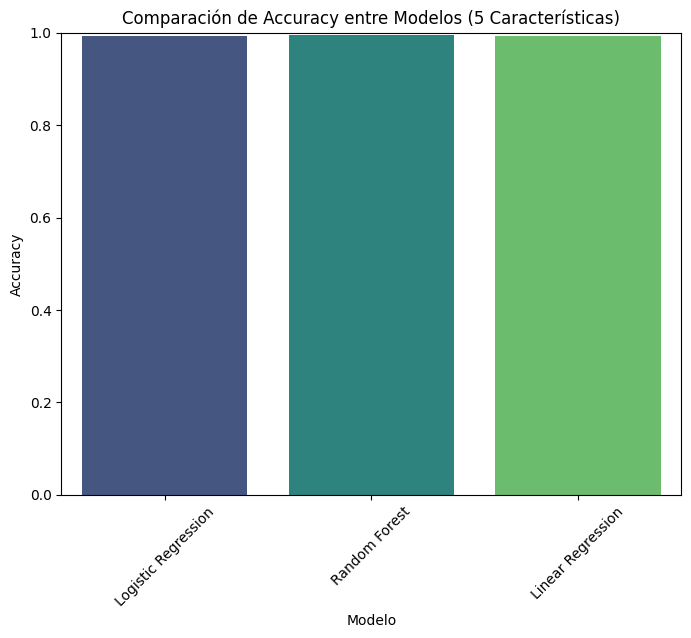

In [27]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Cargar los datos (reemplaza con tu archivo de datos)
data = pd.read_csv("credit_card_transactions.csv")

# Tomar el 5% de los datos desde el inicio
data = data.sample(frac=0.1, random_state=42)

# Definir X (características) y y (target)
y = data['is_fraud']
X = data.drop(columns=['is_fraud', 'trans_date_trans_time', 'cc_num', 'merchant', 'street', 'city', 
                       'state', 'zip', 'lat', 'long', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'category'])

# Manejar variables categóricas
X = pd.get_dummies(X, drop_first=True)

# Imputar los valores faltantes con la media de cada columna
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42, stratify=y)

# Normalizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Seleccionar las 5 características más importantes usando Random Forest
rf_temp = RandomForestClassifier(random_state=42)
rf_temp.fit(X_train_scaled, y_train)

# Obtener las 5 características más importantes
importances = rf_temp.feature_importances_
indices = np.argsort(importances)[::-1][:5]  # Índices de las 5 características más importantes

# Reducir X_train y X_test a estas 5 características
X_train_selected = X_train_scaled[:, indices]
X_test_selected = X_test_scaled[:, indices]

# Definir los modelos y sus parámetros
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Linear Regression': LinearRegression()  # Agregar Linear Regression
}

param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs'],
        'max_iter': [100, 500, 1000]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': ['balanced'],
    }
}

# Ajustar y evaluar los modelos con las 5 características seleccionadas
tuned_results = {}

print("\nEvaluación de Modelos con las 5 Características más Importantes:")
results = []

for name, model in models.items():
    print(f"\n{name} - Ajuste de Hiperparámetros")
    
    # Si el modelo tiene un grid de parámetros, realizar el ajuste
    if name in param_grids:
        param_grid = param_grids[name]
        search = RandomizedSearchCV(
            model,
            param_distributions=param_grid,
            n_iter=5,
            scoring='accuracy',
            cv=3,
            random_state=42,
            n_jobs=1
        )
        search.fit(X_train_selected, y_train)
        tuned_results[name] = search.best_params_
        model.set_params(**search.best_params_)
        print(f"Mejores parámetros: {search.best_params_}")
    else:
        print(f"{name} no requiere ajuste de hiperparámetros.")

    # Entrenar el modelo
    model.fit(X_train_selected, y_train)

    # Realizar predicciones
    if name == 'Linear Regression':
        # Predicciones continuas para la regresión lineal
        y_pred_continuous = model.predict(X_test_selected)
        # Convertir las predicciones en clases usando un umbral de 0.5
        y_pred = (y_pred_continuous >= 0.5).astype(int)
    else:
        y_pred = model.predict(X_test_selected)

    # Evaluación
    acc = accuracy_score(y_test, y_pred)
    results.append({'Modelo': name, 'Accuracy': acc})
    print(f"{name} - Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraude', 'Fraude'], yticklabels=['No Fraude', 'Fraude'])
    plt.title(f'Matriz de Confusión: {name}')
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    plt.show()

# Comparación de modelos
results_df = pd.DataFrame(results)
plt.figure(figsize=(8, 6))
sns.barplot(x='Modelo', y='Accuracy', data=results_df, palette='viridis')
plt.title('Comparación de Accuracy entre Modelos (5 Características)')
plt.ylabel('Accuracy')
plt.xlabel('Modelo')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()


In [28]:
# Reducir los datos a las 5 características seleccionadas
X_train_selected = X_train_scaled[:, indices]
X_test_selected = X_test_scaled[:, indices]

# Entrenar un nuevo StandardScaler solo para las 5 características seleccionadas
scaler_selected = StandardScaler()
X_train_selected_scaled = scaler_selected.fit_transform(X_train_selected)
X_test_selected_scaled = scaler_selected.transform(X_test_selected)

# Reentrenar los modelos con las características escaladas reducidas
rf_model = models['Random Forest'].fit(X_train_selected_scaled, y_train)
logistic_model = models['Logistic Regression'].fit(X_train_selected_scaled, y_train)
linear_model = models['Linear Regression'].fit(X_train_selected_scaled, y_train)

# Guardar el nuevo escalador y los modelos
import joblib
joblib.dump(scaler_selected, 'scaler_selected.pkl')
joblib.dump(rf_model, 'random_forest_model.pkl')
joblib.dump(logistic_model, 'logistic_regression_model.pkl')
joblib.dump(linear_model, 'linear_regression_model.pkl')


['linear_regression_model.pkl']